# Advanced Indexing

## Learning Objectives

* Orthogonal vs. Vectorized and Pointwise Indexing

* Fancy DateTime Indexing

## Overview

In the previous notebooks, we learned basic forms of indexing with xarray (positional and name based dimensions, integer and label based indexing), Datetime Indexing, and nearest neighbor lookups. In this tutorial, we will discover more advanced options for vectorized indexing and learn about additional useful methods relating to indexing/selecting data such as masking. 

First, let's import packages needed for this repository: 

In [90]:
import numpy as np
import pandas as pd
import xarray as xr

In this notebook, we’ll use air temperature tutorial dataset from the National Center for Environmental Prediction.  

In [92]:
ds = xr.tutorial.load_dataset("air_temperature")
da = ds.air
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Orthogonal Indexing 

As we learned in the previous tutorial, positional indexing deviates from the behavior exhibited by NumPy when indexing with multiple arrays. However, Xarray pointwise indexing supports the indexing along multiple labeled dimensions using list-like objects similar to NumPy indexing behavior.

If you only provide integers, slices, or unlabeled arrays (array without dimension names, such as `np.ndarray`, `list`, but not `DataArray()`) indexing can be understood as orthogonally (i.e. along independent axes, instead of using NumPy’s broadcasting rules to vectorize indexers). 

*Orthogonal* or *outer* indexing considers one-dimensional arrays in the same way as slices when deciding the output shapes. The principle of outer or orthogonal indexing is that the result mirrors the effect of independently indexing along each dimension with integer or boolean arrays, treating both the indexed and indexing arrays as one-dimensional. This method of indexing is analogous to vector indexing in programming languages like MATLAB, Fortran, and R, where each indexer component independently selects along its corresponding dimension. 

For example : 

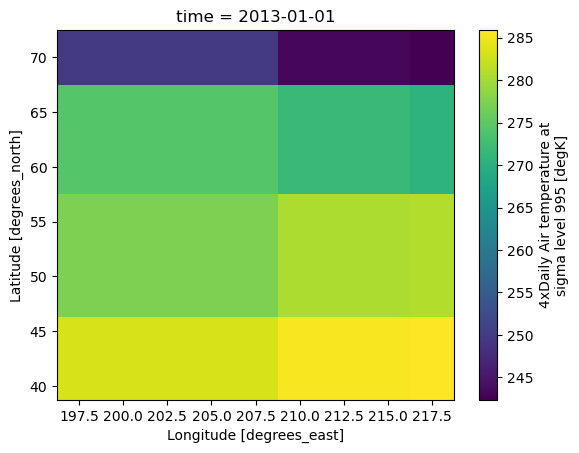

In [93]:
da[0, [2, 4, 10, 13], [1, 6, 7]].plot(); # -- orthogonal indexing

For more flexibility, you can supply `DataArray()` objects as indexers. Dimensions on resultant arrays are given by the ordered union of the indexers’ dimensions:

For example, in the example below we do orthogonal indexing using `DataArray()` objects. 

In [94]:
target_lat = xr.DataArray([31, 41, 42, 42], dims="degrees_north")
target_lon = xr.DataArray([200, 201, 202, 205], dims="degrees_east")

da.sel(lat=target_lat, lon=target_lon, method="nearest") # -- orthogonal indexing 

<xarray.DataArray 'air' (time: 2920, degrees_north: 4, degrees_east: 4)>
array([[[293.1    , 293.1    , 293.29   , 293.29   ],
        [284.6    , 284.6    , 284.9    , 284.19998],
        [282.79   , 282.79   , 283.19998, 282.6    ],
        [282.79   , 282.79   , 283.19998, 282.6    ]],

       [[293.19998, 293.19998, 293.9    , 294.19998],
        [283.29   , 283.29   , 285.19998, 285.19998],
        [281.4    , 281.4    , 282.79   , 283.5    ],
        [281.4    , 281.4    , 282.79   , 283.5    ]],

       [[292.4    , 292.4    , 292.9    , 293.4    ],
        [282.     , 282.     , 283.29   , 284.69998],
        [280.     , 280.     , 280.79   , 282.4    ],
        [280.     , 280.     , 280.79   , 282.4    ]],

       ...,

       [[288.88998, 288.88998, 289.19   , 290.88998],
        [282.49   , 282.49   , 281.99   , 281.99   ],
        [281.29   , 281.29   , 281.29   , 280.99   ],
        [281.29   , 281.29   , 281.29   , 280.99   ]],

       [[288.29   , 288.29   , 289.19   , 290.79   ],
        [282.09   , 282.09   , 281.59   , 282.38998],
        [280.99   , 280.99   , 280.38998, 280.59   ],
        [280.99   , 280.99   , 280.38998, 280.59   ]],

       [[289.49   , 289.49   , 290.38998, 291.59   ],
        [282.09   , 282.09   , 281.99   , 283.09   ],
        [281.38998, 281.38998, 280.59   , 280.99   ],
        [281.38998, 281.38998, 280.59   , 280.99   ]]], dtype=float32)
Coordinates:
    lat      (degrees_north) float32 30.0 40.0 42.5 42.5
    lon      (degrees_east) float32 200.0 200.0 202.5 205.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: degrees_north, degrees_east
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In the above example, you can see how the output shape is `time` x `lats` x `lons`. 


But what if we would like to find the information from the nearest grid cell to a collection of specified points (for example, weather stations or tower data)?

## Vectorized or Pointwise Indexing

Like NumPy and pandas, Xarray supports indexing many array elements at once in a
*vectorized* manner. 

**Vectorized indexing** or **Pointwise Indexing** using `DataArrays()` can be used to extract information from the nearest grid cells of interest, for example, the nearest climate model grid cells to a collection of specified weather station latitudes and longitudes.

```{hint}
To trigger vectorized indexing behavior, you will need to provide the selection dimensions with a new shared output dimension name. 
```

In the example below, the selections of the closest latitude and longitude are renamed to an output dimension named `points`:

In [95]:
# Define target latitude and longitude (where weather stations might be)
lat_points = xr.DataArray([31, 41, 42, 42], dims="points")
lon_points = xr.DataArray([200, 201, 202, 205], dims="points")
lat_points

<xarray.DataArray (points: 4)>
array([31, 41, 42, 42])
Dimensions without coordinates: points

In [96]:
lon_points

<xarray.DataArray (points: 4)>
array([200, 201, 202, 205])
Dimensions without coordinates: points

Now, retrieve data at the grid cells nearest to the target latitudes and longitudes (weather stations):

In [97]:
da.sel(lat=lat_points, lon=lon_points, method="nearest")

<xarray.DataArray 'air' (time: 2920, points: 4)>
array([[293.1    , 284.6    , 283.19998, 282.6    ],
       [293.19998, 283.29   , 282.79   , 283.5    ],
       [292.4    , 282.     , 280.79   , 282.4    ],
       ...,
       [288.88998, 282.49   , 281.29   , 280.99   ],
       [288.29   , 282.09   , 280.38998, 280.59   ],
       [289.49   , 282.09   , 280.59   , 280.99   ]], dtype=float32)
Coordinates:
    lat      (points) float32 30.0 40.0 42.5 42.5
    lon      (points) float32 200.0 200.0 202.5 205.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: points
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

👆 Please notice how the shape of our `DataArray` is `time` x `points`, extracting time series for each weather stations. 


In [98]:
da.sel(lat=lat_points, lon=lon_points, method="nearest").dims

('time', 'points')

```attention}
Please note that slices or sequences/arrays without named-dimensions are treated as if they have the same dimension which is indexed along.
```

For example:

In [99]:
da.sel(lat=[20, 30, 40], lon=lon_points, method="nearest")

<xarray.DataArray 'air' (time: 2920, lat: 3, points: 4)>
array([[[296.6    , 296.6    , 296.19998, 296.4    ],
        [293.1    , 293.1    , 293.29   , 293.29   ],
        [284.6    , 284.6    , 284.9    , 284.19998]],

       [[296.4    , 296.4    , 295.9    , 296.19998],
        [293.19998, 293.19998, 293.9    , 294.19998],
        [283.29   , 283.29   , 285.19998, 285.19998]],

       [[295.6    , 295.6    , 295.4    , 295.4    ],
        [292.4    , 292.4    , 292.9    , 293.4    ],
        [282.     , 282.     , 283.29   , 284.69998]],

       ...,

       [[294.79   , 294.79   , 295.29   , 297.49   ],
        [288.88998, 288.88998, 289.19   , 290.88998],
        [282.49   , 282.49   , 281.99   , 281.99   ]],

       [[293.69   , 293.69   , 293.88998, 295.38998],
        [288.29   , 288.29   , 289.19   , 290.79   ],
        [282.09   , 282.09   , 281.59   , 282.38998]],

       [[293.79   , 293.79   , 293.69   , 295.09   ],
        [289.49   , 289.49   , 290.38998, 291.59   ],
        [282.09   , 282.09   , 281.99   , 283.09   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 20.0 30.0 40.0
    lon      (points) float32 200.0 200.0 202.5 205.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: points
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

```{warning}
If an indexer is a `DataArray()`, its coordinates should not conflict with the selected subpart of the target array (except for the explicitly indexed dimensions with `.loc`/`.sel`). Otherwise, `IndexError` will be raised!
```

Analogously, label-based pointwise-indexing is also possible by the `.sel()` method:

In [100]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IA", "IL", "IN"]),
    ],
)
times = xr.DataArray(
    pd.to_datetime(["2000-01-03", "2000-01-02", "2000-01-01"]), dims="new_time"
)


# -- get data for each state and each time:
da.sel(space=xr.DataArray(["IA", "IL", "IN"], dims=["new_time"]), time=times)



<xarray.DataArray (new_time: 3)>
array([0.87902737, 0.06690113, 0.01799672])
Coordinates:
    time      (new_time) datetime64[ns] 2000-01-03 2000-01-02 2000-01-01
    space     (new_time) <U2 'IA' 'IL' 'IN'
  * new_time  (new_time) datetime64[ns] 2000-01-03 2000-01-02 2000-01-01

## Align and Reindex 

Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.


In [ ]:
da

In [ ]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IL", "IA", "IN"]),
    ],
)
da

In [ ]:
da.reindex(space=["IA", "CA"])

In [ ]:
new_time = pd.date_range('2013-02-01', periods=20, freq='H')

In [ ]:
da.reindex(time=new_time)

## Additional Resources

- [Xarray Docs - Indexing and Selecting Data](https://docs.xarray.dev/en/stable/indexing.html)
